In [1]:
import numpy as np
import os
import netCDF4
from scipy import stats
from sstanalysis import gfd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [3]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

# SST #

1649 1899 1494 1667
11.767448308 49.2027441065 140.05 232.085004027
(500, 900) (500, 900) (500, 900)


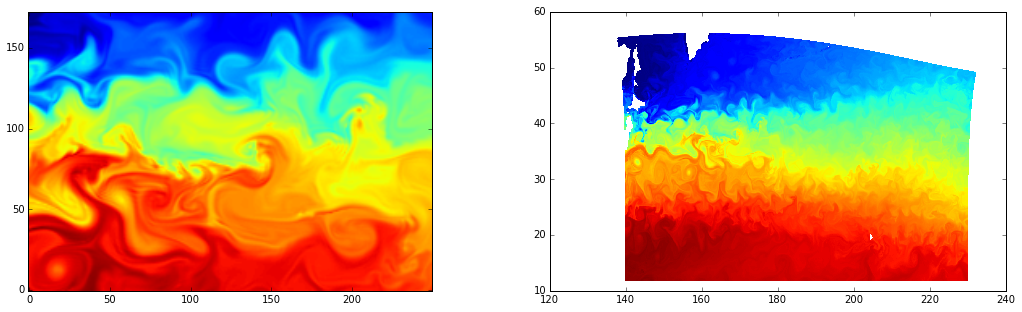

In [27]:
roll = -1000
west, est, sud, nord = 154.9, 180., 30., 45.4
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])

base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)

SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
print imin, imax, jmin, jmax

SST_domain = SST[..., jmin:jmax, imin:imax]
U_domain = U[..., jmin:jmax, imin:imax]
jLs, jLe = (1300,1800)
iLs, iLe = (1500,2400)
print tlat[jLs,iLs], tlat[jLe,iLe], tlon[jLs,iLs], tlon[jLe,iLe]

plt.figure(figsize=(18,5))
plt.subplot(121)
plt.imshow(SST_domain, origin='bottom')
plt.subplot(122)
plt.pcolormesh(tlon[jLs:jLe, iLs:iLe], tlat[jLs:jLe, iLs:iLe], SST[..., jLs:jLe, iLs:iLe])

#plt.figure(figsize=(10,10))
#plt.imshow(U_domain, origin='bottom')
print tlon[jLs:jLe, iLs:iLe].shape, tlat[jLs:jLe, iLs:iLe].shape, SST[..., jLs:jLe, iLs:iLe].shape

In [16]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (12., 54.)
lon_start, lon_end = (140., 232.1)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
Lon = np.zeros((Degy,Degx))
Lat = np.zeros((Degy,Degx))
slopes_Feb = np.zeros((Degy,Degx))
slopes_Aug = np.zeros((Degy,Degx))
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon.shape

9 4
(4, 9)


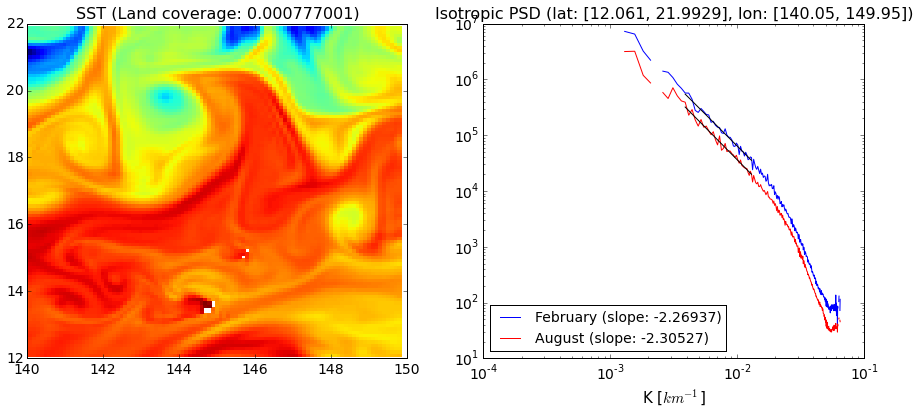

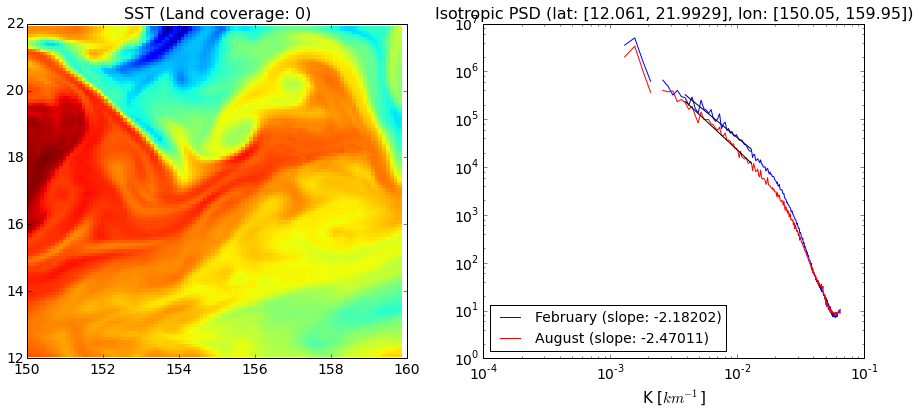

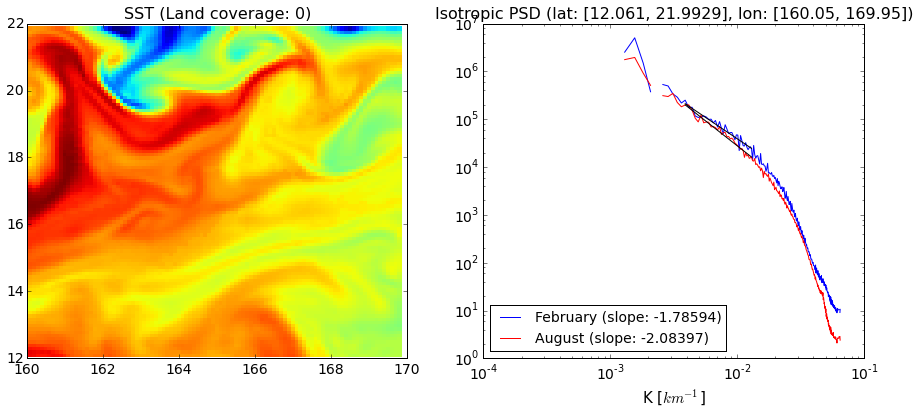

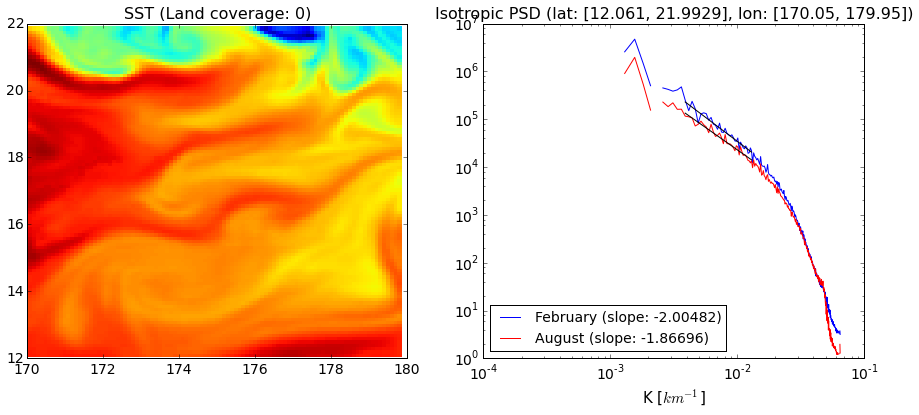

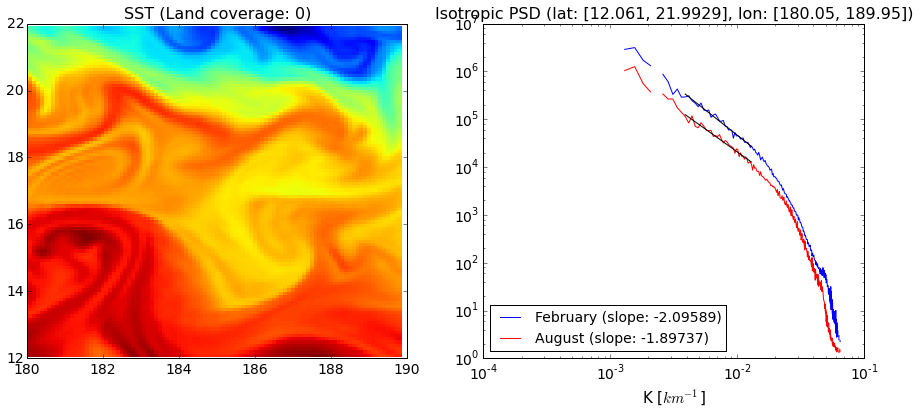

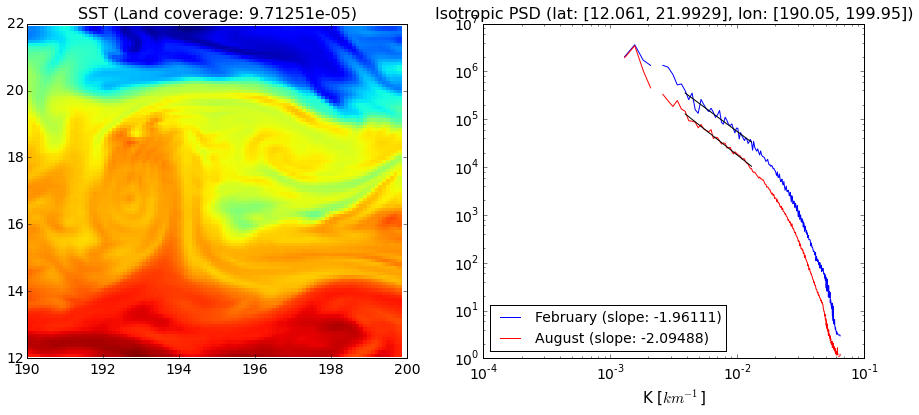

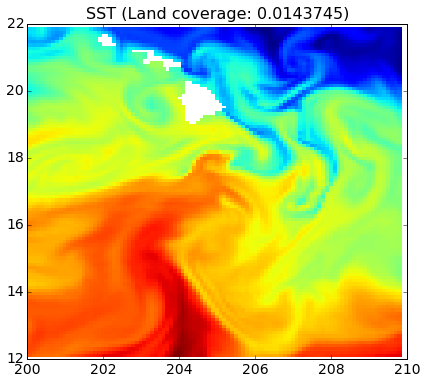

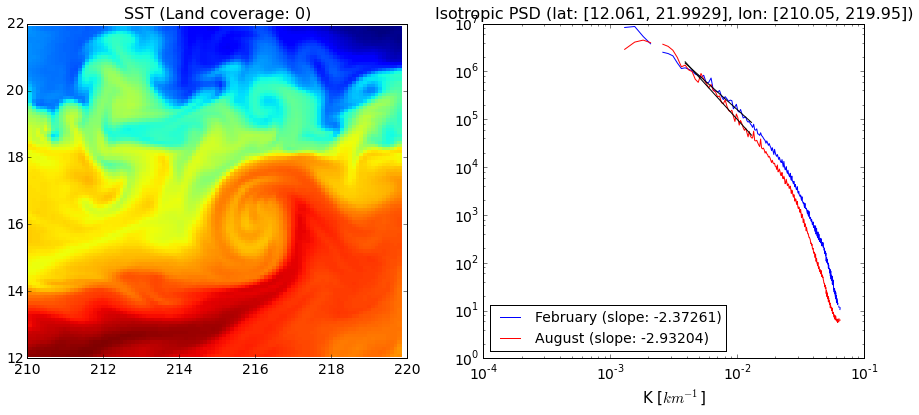

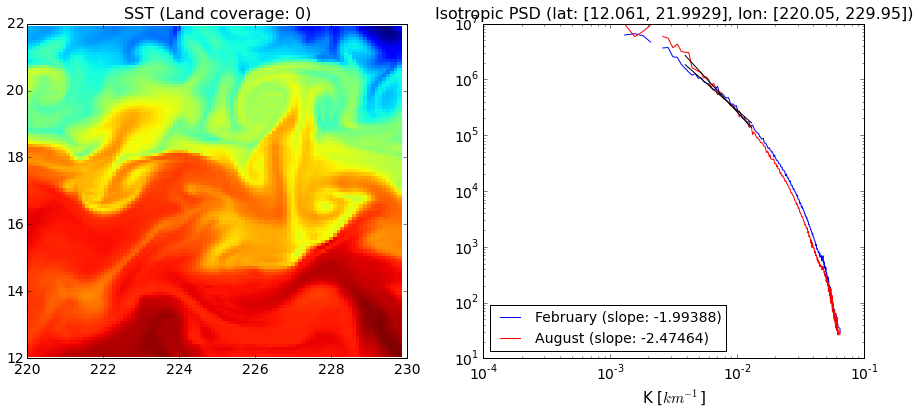

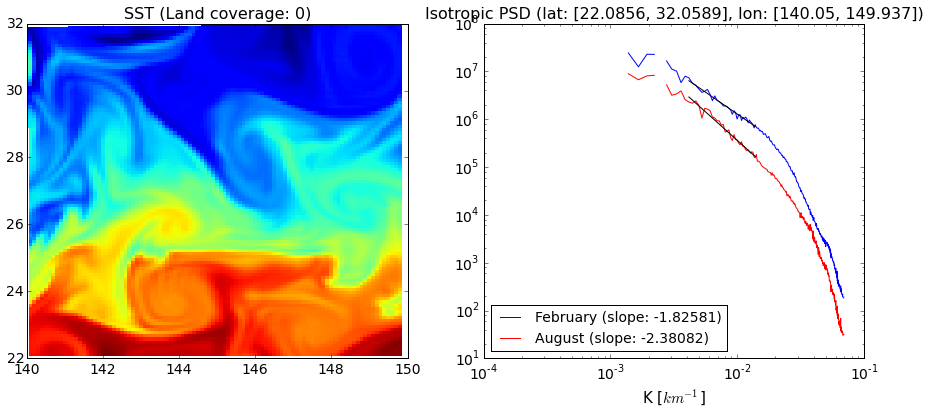

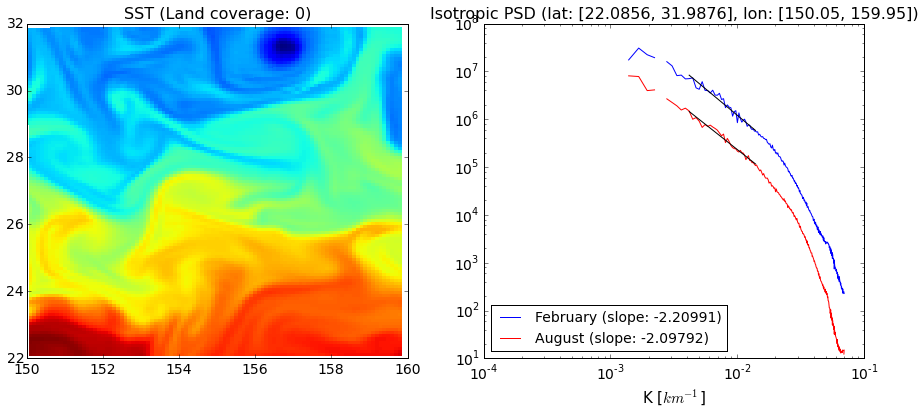

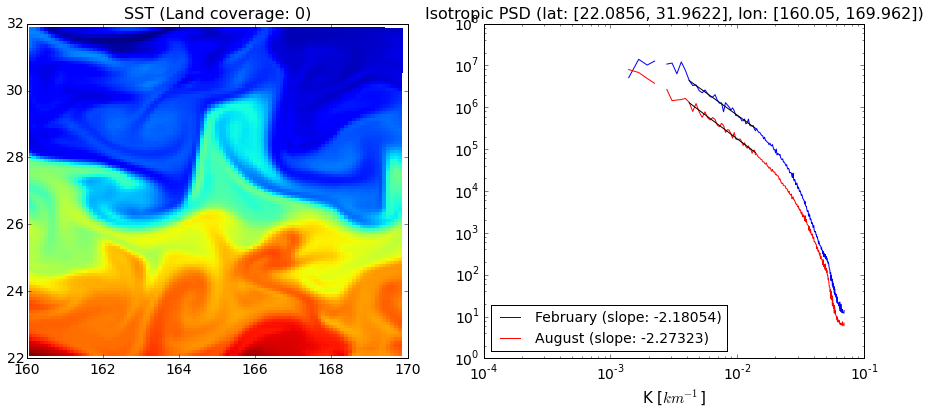

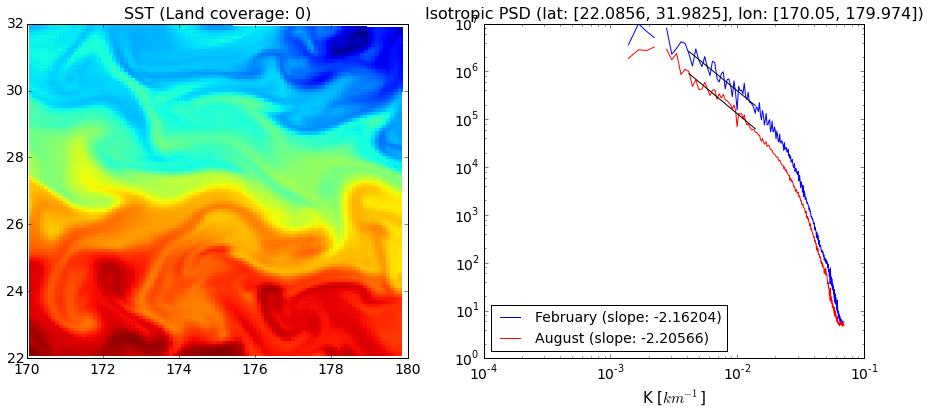

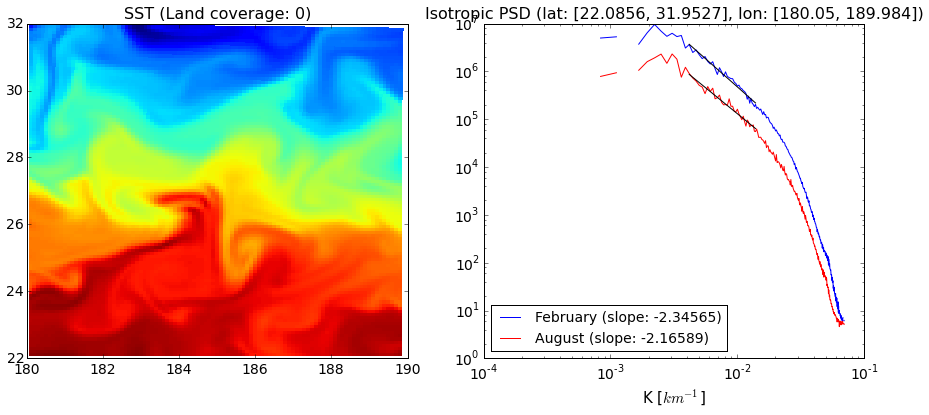

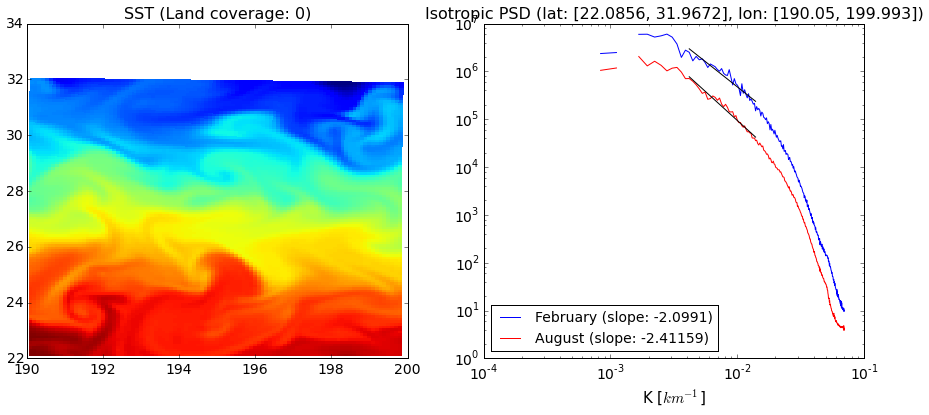

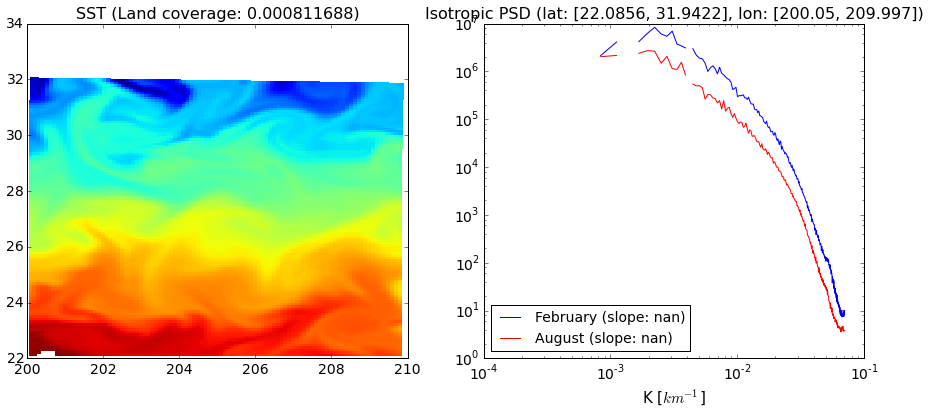

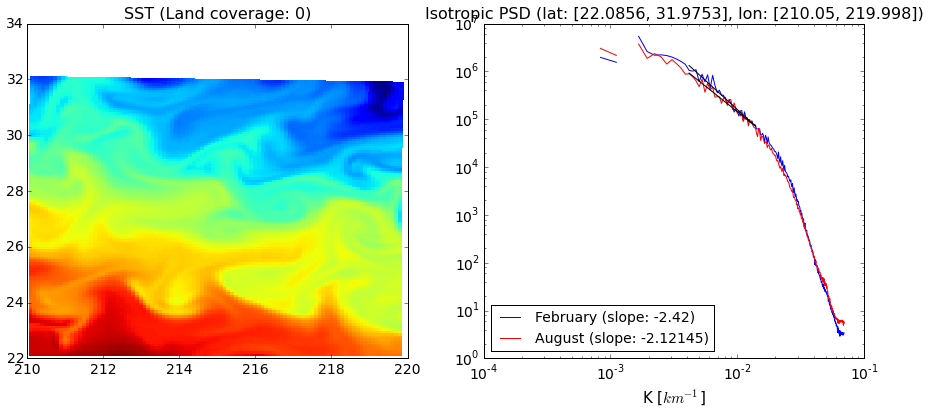

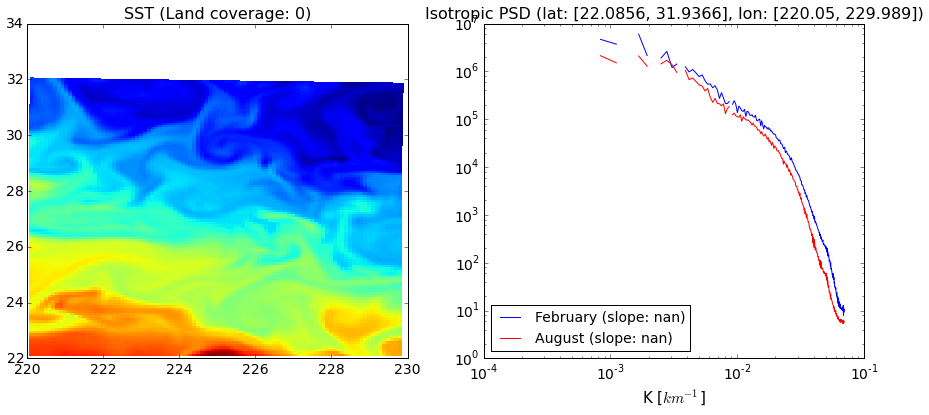

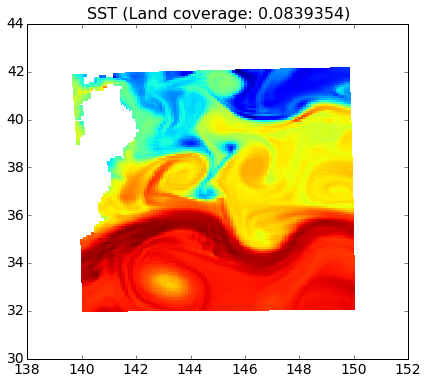

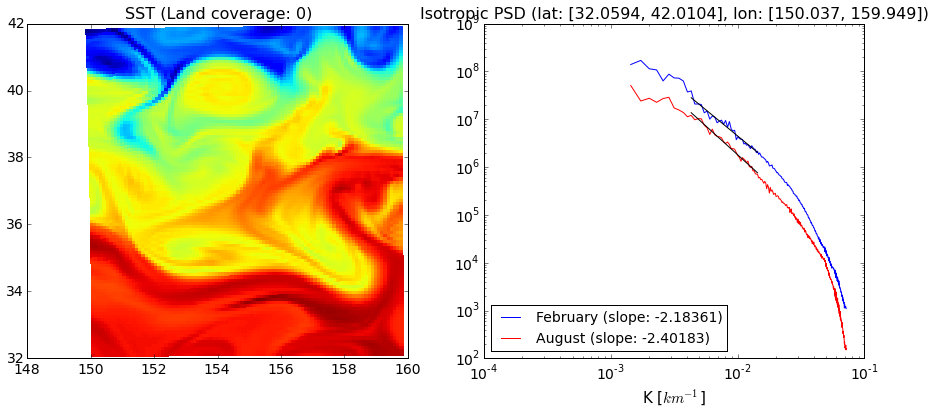

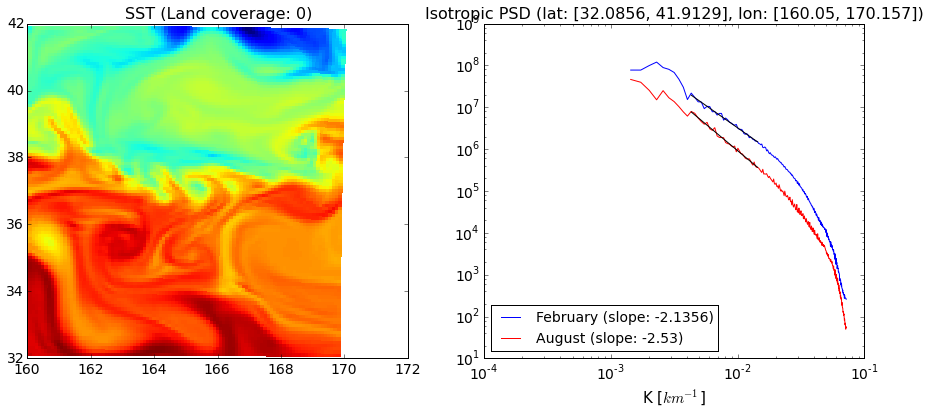

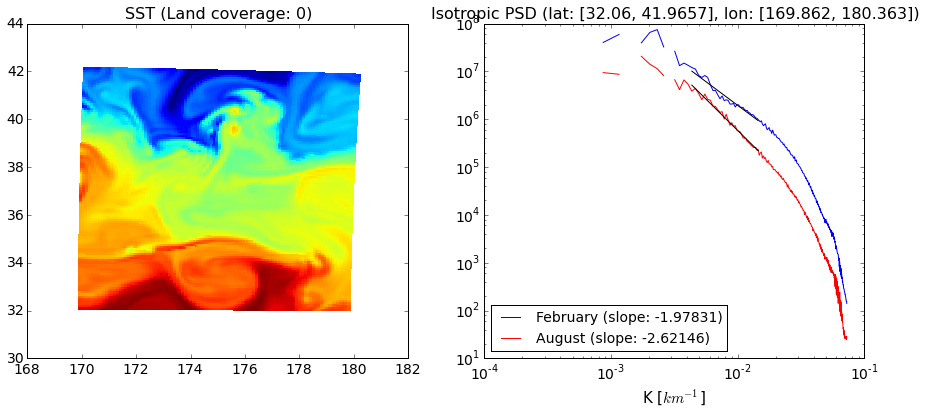

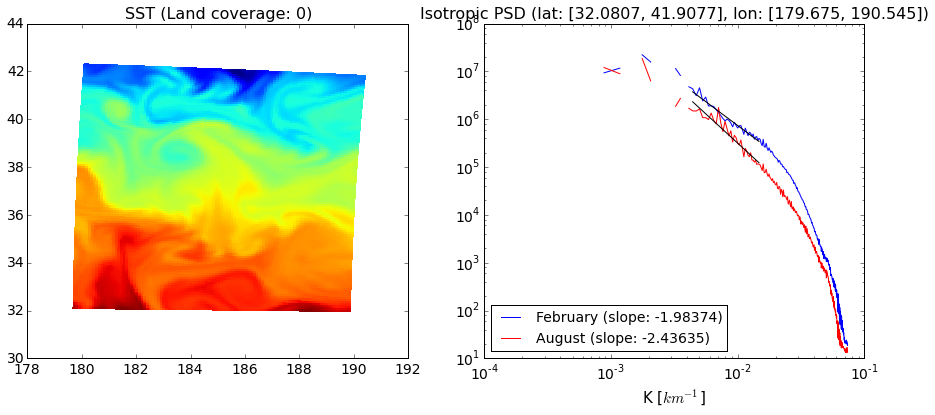

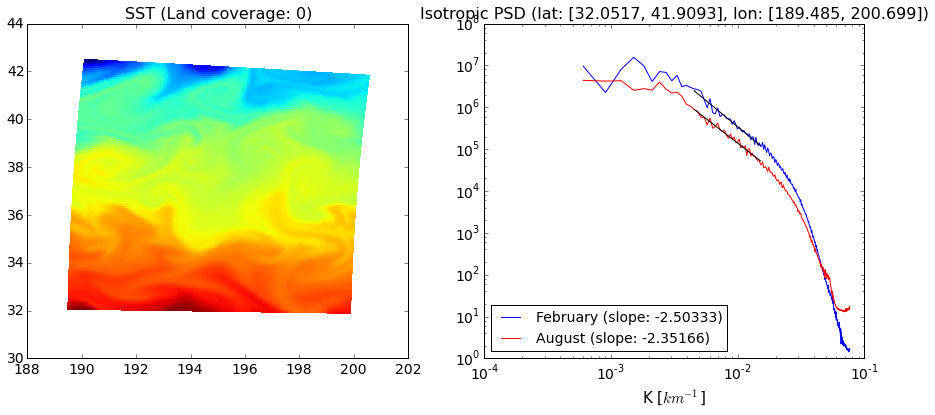

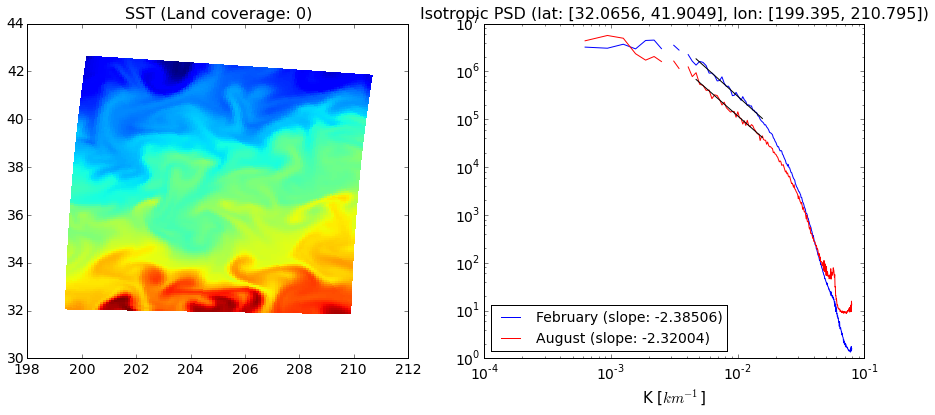

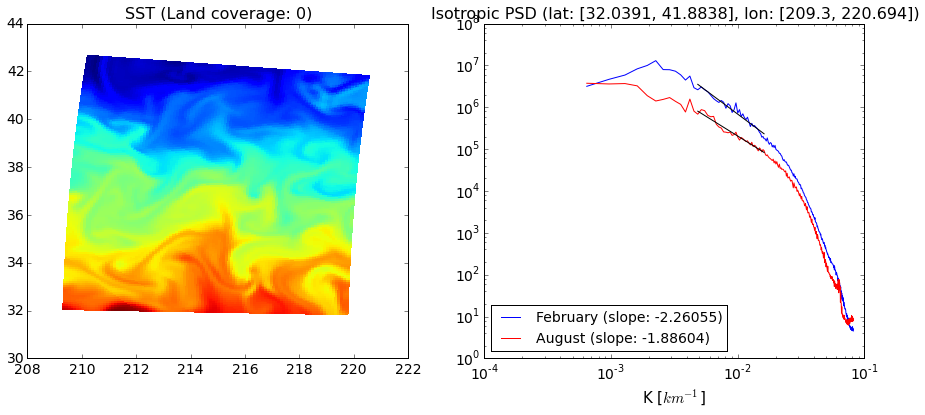

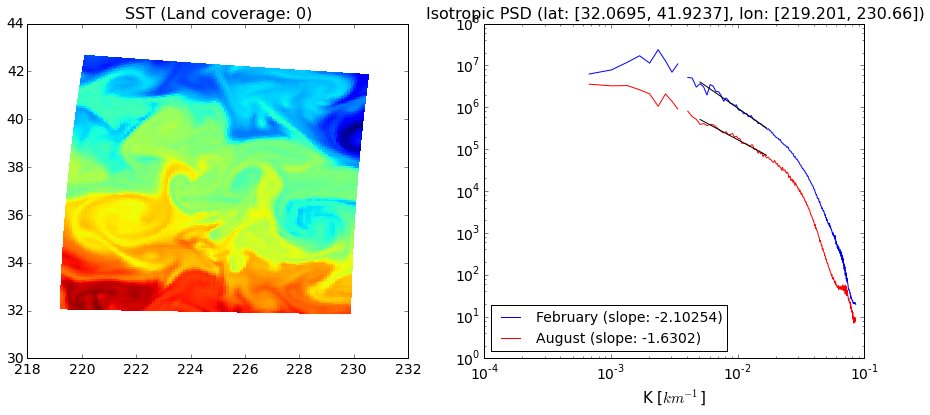

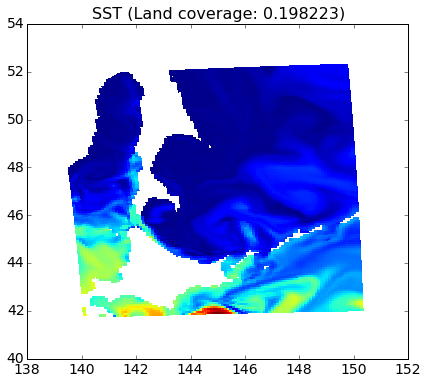

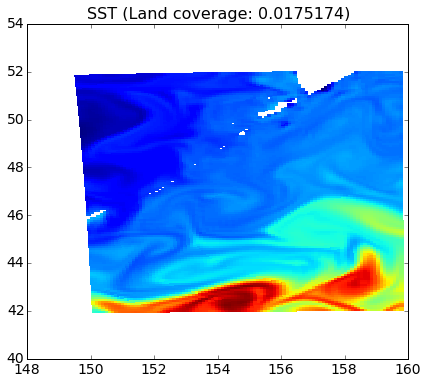

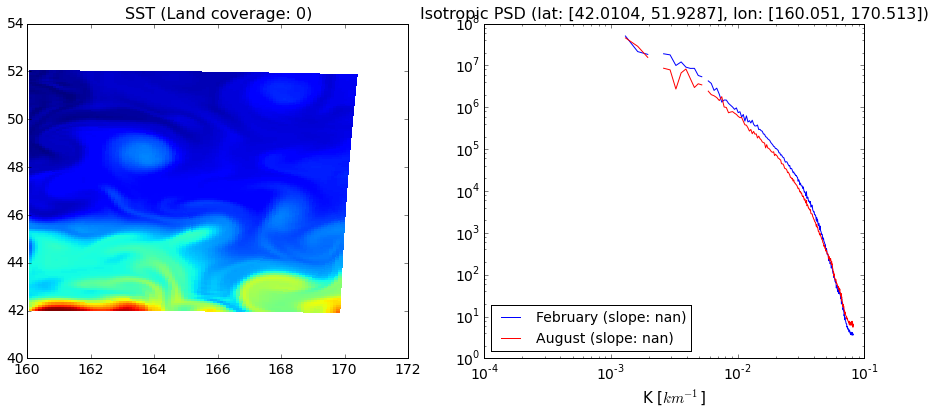

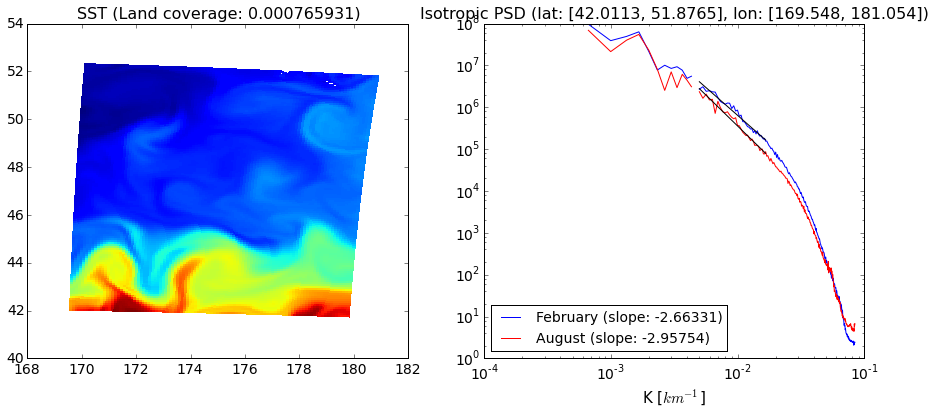

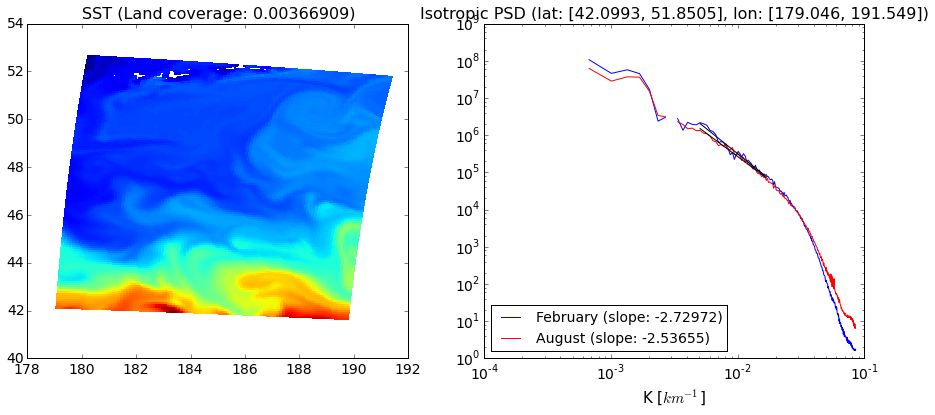

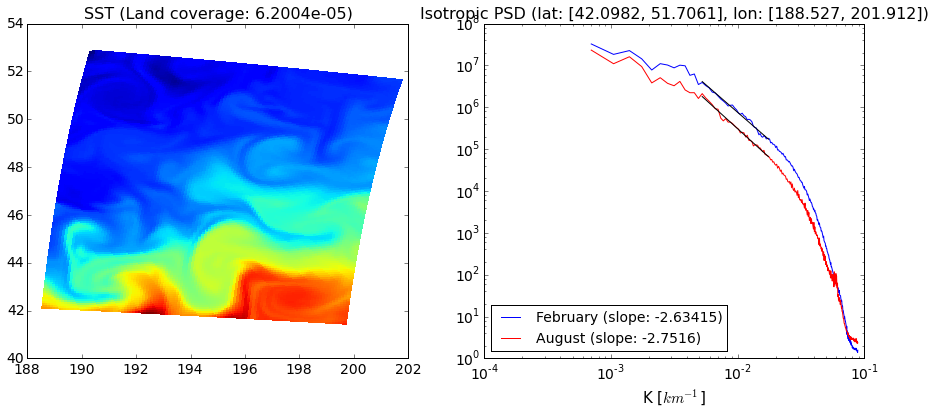

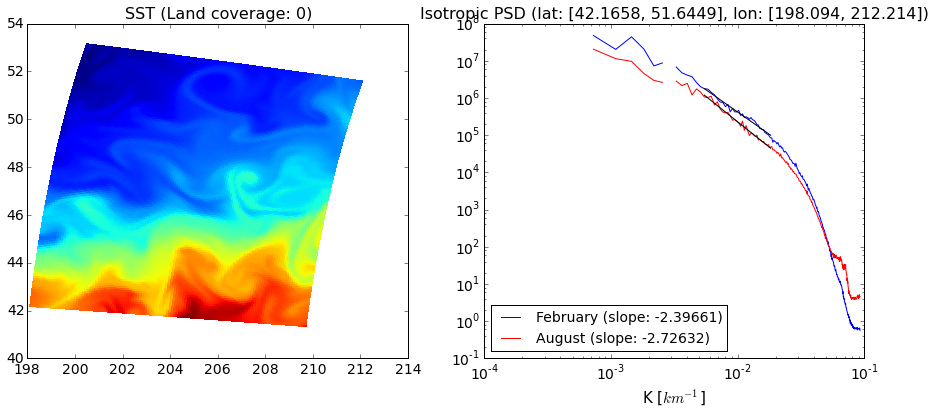

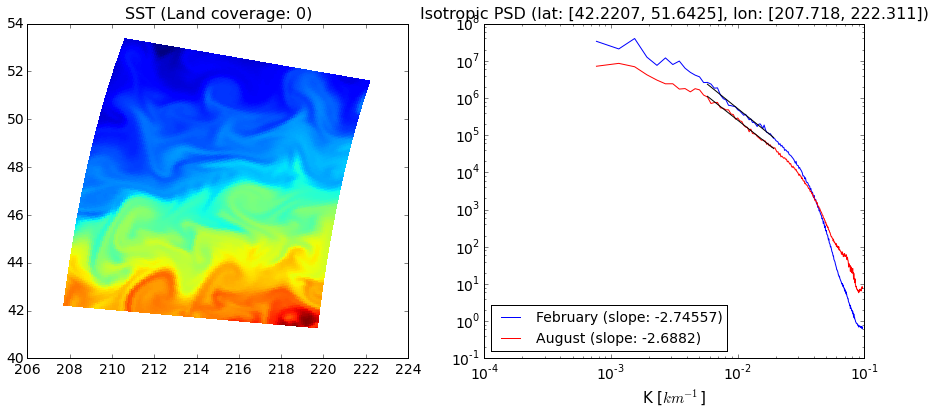

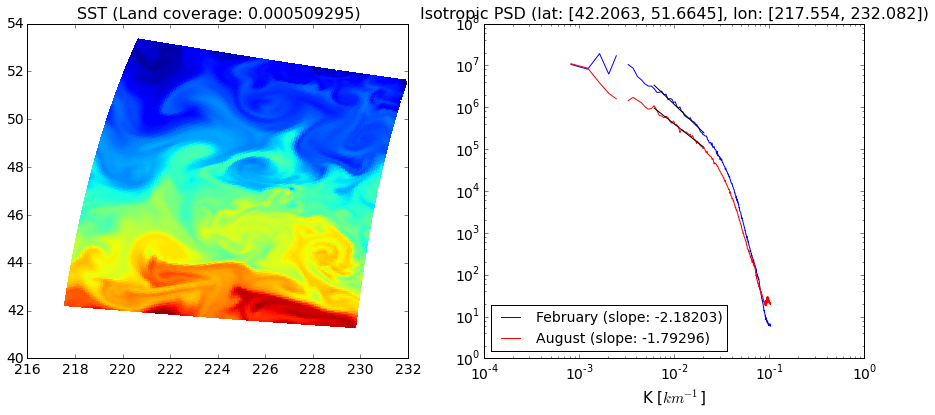

In [17]:
j,i = (0,0)
while north<=lat_end:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end:
        # February
        NtFeb = 0.
        # load data files
        nday = 1
        for yearnum in np.arange(1,6):
            daynum = 0
            #for month in np.arange(1,13):
            fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
            #print fname
            p = popmodel.POPFile(fname)
            #T = p.nc.variables['SST'][:]
            Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                        lonrange=(west,east), latrange=(south,north))
            if yearnum == 1:
                N = len(Ki)
                isospec_sum_Feb = np.zeros(N)
            isospec_sum_Feb += isospec_Feb
            #NtFeb += Nt_Feb

        isospec_ave_Feb = isospec_sum_Feb/yearnum
        
        # August
        NtAug = 0.
        # load data files
        nday = 1
        for yearnum in np.arange(1,6):
            daynum = 0
            #for month in np.arange(1,13):
            fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
            #print fname
            p = popmodel.POPFile(fname)
            #T = p.nc.variables['SST'][:]
            Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                            lonrange=(west,east), latrange=(south,north))
            if yearnum == 1:
                N = len(Ki)
                isospec_sum_Aug = np.zeros(N)
            isospec_sum_Aug += isospec_Aug
            #NtAug += Nt_Aug

        isospec_ave_Aug = isospec_sum_Aug/yearnum
        
        Ns = 15
        Ne = N/5
        ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
        ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
        U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        SST_domain = SST[..., jmin:jmax, imin:imax]
        U_domain = U[..., jmin:jmax, imin:imax]


        if land_frac<MAX_LAND:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
            slopes_Feb[j,i] = ps_slope_Feb
            slopes_Aug[j,i] = ps_slope_Aug
            
            plt.figure(figsize=(15,6))
            plt.subplot(121)
            plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
            plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.subplot(122)
            plt.loglog(Ki*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
            plt.loglog(Ki*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
            plt.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb, 'k')
            plt.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug, 'k')
            plt.xlabel('K [$km^{-1}$]', fontsize=15)
            plt.title('Isotropic PSD (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
            plt.legend(loc='lower left', fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
            slopes_Feb[j,i] = np.nan
            slopes_Aug[j,i] = np.nan
            
            plt.figure(figsize=(15,6))
            plt.subplot(121)
            plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
            plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
        

        west = east
        east = west+dlon
        i += 1
    south = north
    north = south+dlat
    j += 1

[[-2.30527349 -2.47011019 -2.08396865 -1.8669613  -1.89736701 -2.09488016
          nan -2.93204231 -2.4746424 ]
 [-2.38082447 -2.09792348 -2.27323302 -2.20566196 -2.16588562 -2.41158953
          nan -2.1214533          nan]
 [        nan -2.40183133 -2.53000008 -2.62146451 -2.43635216 -2.35165758
  -2.32003842 -1.88604266 -1.63019958]
 [        nan         nan         nan -2.95753668 -2.53654667 -2.75160439
  -2.72631731 -2.68819722 -1.79295853]]
[[ 140.05        150.05        160.05        170.05        180.05        190.05
   200.05        210.05        220.05      ]
 [ 140.05        150.05        160.05        170.05        180.05        190.05
   200.05        210.05        220.05      ]
 [ 140.02643947  150.03749643  160.05006412  169.86238293  179.67459562
   189.48509459  199.39458911  209.29963377  219.20080084]
 [ 140.06104108  150.04671062  160.05106356  169.5481      179.045603
   188.52743036  198.09448378  207.7181589   217.55370814]]


<matplotlib.colorbar.Colorbar instance at 0x7ff640994ab8>

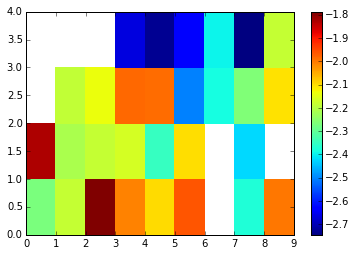

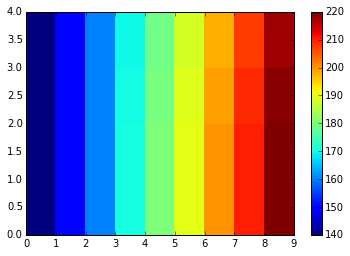

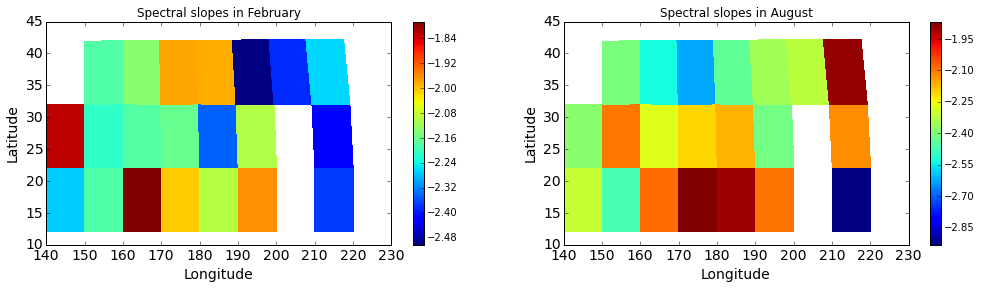

In [24]:
print slopes_Aug
print Lon

plt.figure()
plt.pcolormesh(np.ma.masked_invalid(slopes_Feb))
plt.colorbar()

plt.figure()
plt.pcolormesh(Lon)
plt.colorbar()

plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(slopes_Feb))
plt.title('Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(slopes_Aug))
plt.title('Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.colorbar()